<a href="https://colab.research.google.com/github/karencfisher/Hotel-Cancellations/blob/master/notebooks/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Installations of dependencies

!pip install category_encoders==2.*
!pip install eli5

!wget https://raw.githubusercontent.com/karencfisher/Hotel-Cancellations/master/tools.py

!pip install pdpbox
!pip install shap


     |████████████████████████████████| 81kB 3.4MB/s 
     |████████████████████████████████| 112kB 4.6MB/s 
--2020-06-16 08:34:25--  https://raw.githubusercontent.com/karencfisher/Hotel-Cancellations/master/tools.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10064 (9.8K) [text/plain]
Saving to: ‘tools.py’

tools.py            100%[===================>]   9.83K  --.-KB/s    in 0s      

2020-06-16 08:34:26 (81.9 MB/s) - ‘tools.py’ saved [10064/10064]

     |████████████████████████████████| 57.7MB 77kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp36-none-any.whl size=57690722 sha256=6e64744ca27e439a012ad87588802e476b17f85c20f87d6098eb0ac76a4431cc
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a

In [2]:
# Import libraries

import tools
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

import category_encoders as ce

from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import LabelEncoder,  StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.utils import compute_class_weight
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline as make_imb_pipeline

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
import shap

import eli5
from eli5.sklearn import PermutationImportance

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions

In [0]:
# Load dataset

url = 'https://raw.githubusercontent.com/karencfisher/Hotel-Cancellations/master/hotel_bookings.csv'
df = pd.read_csv(url)

# Correct some target values -- should be 'no-show' or 'cancellation' when checkout and
# arrival dates same indicating no stay
df = tools.fixTarget(df)

# Convert no shows to cancellations
df['reservation_status'] = df['reservation_status'].replace('No-Show', 'Canceled')

# Prepare training, validation, and test sets
X = df.drop('reservation_status', axis=1)
y = df['reservation_status']
y = y == 'Canceled'

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42,
                                                    stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.3,
                                                  random_state=42, stratify=y_train)

In [4]:
pipe = make_pipeline(tools.wrangleData(),
                          ce.OrdinalEncoder(),
                          SimpleImputer(),
                          SelectKBest(score_func=chi2, k='all'))

pipe.fit(X_train, y_train)

scores = pd.Series(pipe.named_steps['selectkbest'].scores_, 
                   pipe.named_steps['wrangledata'].columns_)

scores.sort_values(ascending=False)

lead_time                      504564.783473
days_in_waiting_list            19539.001590
country                         14295.423305
previous_cancellations           5663.770897
total_of_special_requests        3606.199705
room_type_changed                2791.917582
booking_changes                  2333.623388
required_car_parking_spaces      2157.184783
deposit_type                     1222.317541
market_segment                    292.399885
is_repeated_guest                 208.829921
customer_type                     201.617237
hotel                             125.503267
nights_stay                        29.704672
adults                             25.129085
arrival_date_week_number           19.036394
meal                                3.657148
adr                                 0.427247
dtype: float64

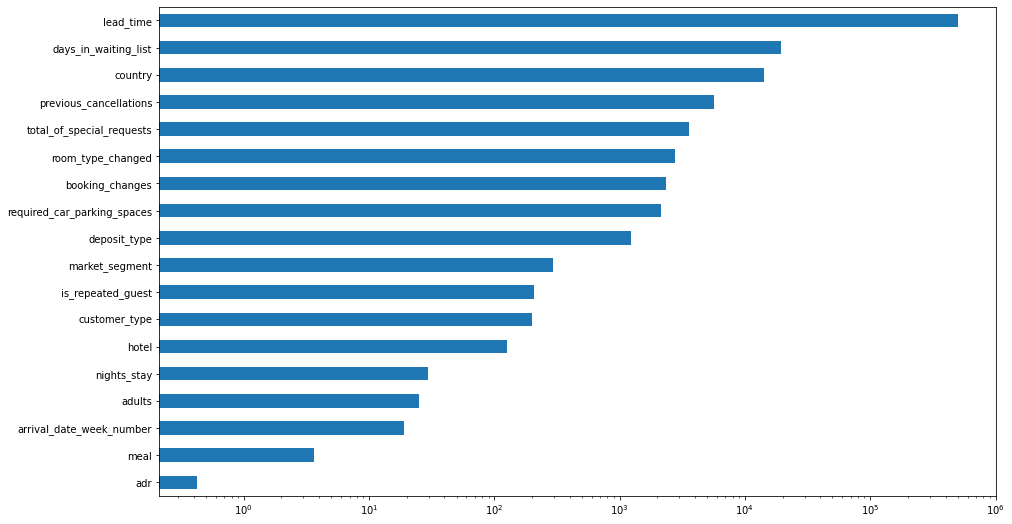

In [5]:
plt.figure(figsize=(15, len(pipe.named_steps['wrangledata'].columns_) / 2))
scores.sort_values().plot.barh()
plt.xscale('log');

In [6]:
baseline = make_pipeline(tools.wrangleData(),
                         ce.OrdinalEncoder(),
                         SimpleImputer(),
                         DummyClassifier())

tools.tryModel(baseline, X_train, y_train, X_val, y_val)



Train score = 53.45891523221825 %
Validate score = 52.915603063178054 %




'Confusion Matrix'

,False,True
False,9755,5882
True,5899,3536


'Metrics'

,precision,recall,f1-score
False,0.623163,0.623841,0.623502
True,0.375451,0.374775,0.375113


In [7]:
lr_pipeline = make_pipeline(tools.wrangleData(),
                            ce.OrdinalEncoder(),
                            SimpleImputer(),
                            StandardScaler(),
                            LogisticRegression(n_jobs=-1,
                                               solver='lbfgs'))

tools.tryModel(lr_pipeline, X_train, y_train, X_val, y_val)



Train score = 79.1080494350524 %
Validate score = 79.96569878749202 %




'Confusion Matrix'

,False,True
False,14558,1079
True,3944,5491


'Metrics'

,precision,recall,f1-score
False,0.786834,0.930997,0.852866
True,0.835769,0.581982,0.686161


In [76]:
model = RandomForestClassifier(random_state=42,
                              n_jobs=-1,
                              max_depth=35,
                              min_samples_leaf=2,
                              min_samples_split=2,
                              class_weight='balanced')

rf_pipeline1 = make_pipeline(tools.wrangleData(),
                             ce.OrdinalEncoder(),
                             SimpleImputer(),
                             model)

tools.tryModel(rf_pipeline1, X_train, y_train, X_val, y_val)



Train score = 96.39835216492025 %
Validate score = 87.86295469049138 %




'Confusion Matrix'

,False,True
False,14207,1430
True,1613,7822


'Metrics'

,precision,recall,f1-score
False,0.898040,0.908550,0.903265
True,0.845439,0.829041,0.837160


Accuracy score



country                        0.071187
total_of_special_requests      0.061974
lead_time                      0.060227
market_segment                 0.050367
deposit_type                   0.046354
adr                            0.025670
customer_type                  0.024689
previous_cancellations         0.023644
room_type_changed              0.020485
nights_stay                    0.016760
arrival_date_week_number       0.015451
required_car_parking_spaces    0.014367
booking_changes                0.011551
hotel                          0.010362
meal                           0.004906
adults                         0.004802
is_repeated_guest              0.001460
days_in_waiting_list           0.000997
dtype: float64

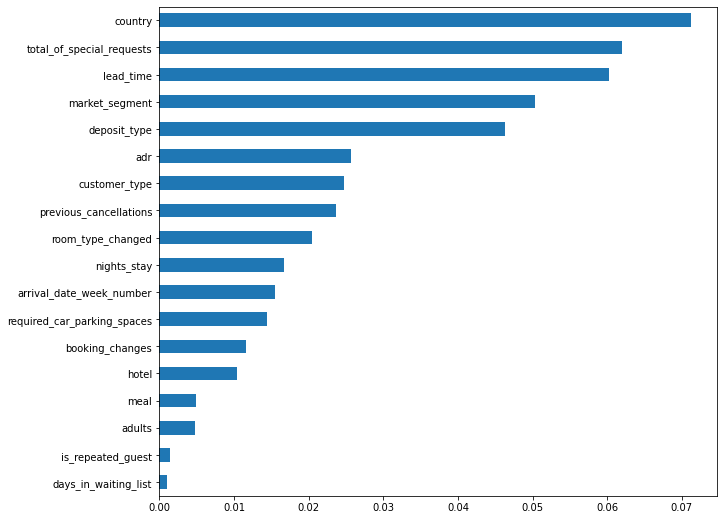

In [94]:
tools.permutationImports(model, X_train, y_train, X_val, y_val)

In [0]:
def plotFeature(model, df, feature, cat_features=[], encodings=None):
    plt.rcParams['figure.dpi'] = 72
    isolated = pdp_isolate(model=model, 
                          dataset=df,
                          model_features=df.columns,
                          feature=feature)

    pdp_plot(isolated, feature_name=feature)
    if encodings == None:
        return
    elif feature in cat_features:
        for item in encodings:
            if item['col'] == feature:
                feature_mapping = item['mapping']
                feature_mapping = feature_mapping[feature_mapping.index.dropna()]
                cat_names = feature_mapping.index.tolist()
                cat_codes = feature_mapping.values.tolist()
                plt.xticks(cat_codes, cat_names)

    plt.show()

In [91]:
trans = make_pipeline(tools.wrangleData(),
                      ce.OrdinalEncoder(),
                      SimpleImputer())

trans.fit(X_train, y_train)
wrangler = trans.named_steps['wrangledata']
encoder = trans.named_steps['ordinalencoder']

X_train_enc = trans.transform(X_train)
X_train_enc = pd.DataFrame(X_train_enc, columns=wrangler.columns_)
X_val_enc = pd.DataFrame(trans.transform(X_val), columns=wrangler.columns_)

model.fit(X_train_enc, y_train)

cat_features = tools.wrangleData().transform(X_train). \
                    select_dtypes(exclude='number').columns.tolist()
cat_features

['hotel',
 'meal',
 'country',
 'market_segment',
 'deposit_type',
 'customer_type',
 'room_type_changed']

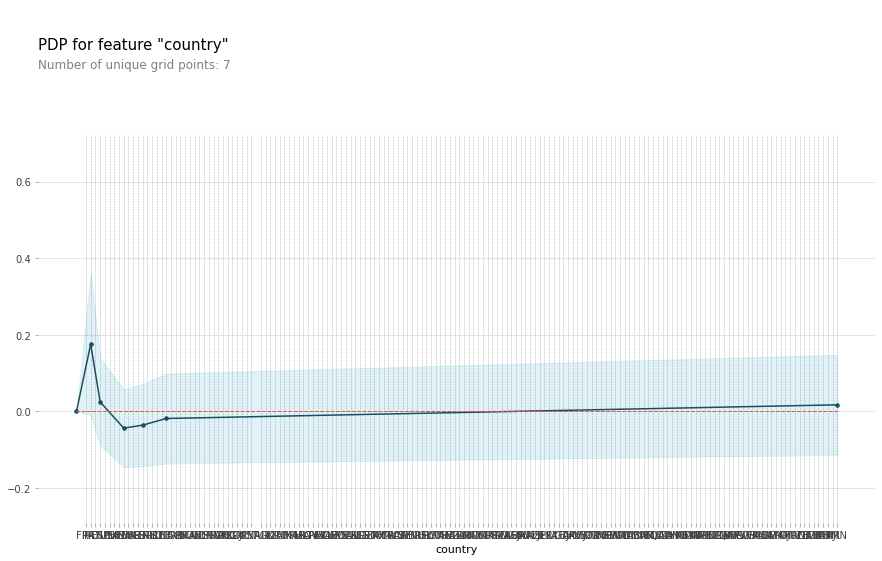

In [92]:
plotFeature(model, X_val_enc, 'country', cat_features, encoder.mapping)

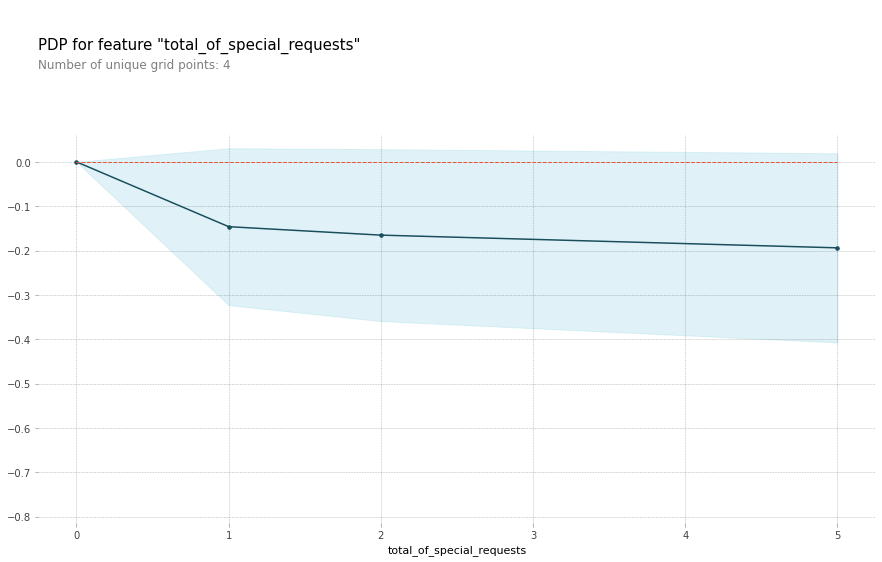

In [93]:
plotFeature(model, X_val_enc, 'total_of_special_requests', cat_features, encoder.mapping)

In [0]:
def shapPlot(model, input_data):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(input_data)

    shap.initjs()
    return shap.force_plot(base_value=explainer.expected_value[1],
                    shap_values=shap_values[1],
                    features=input_data,
                    link='logit')

In [108]:
df = X_val_enc.copy()
y_pred = model.predict_proba(X_val_enc)
df['predicted_status'] = y_pred[:, 1]
df.sort_values(by='predicted_status', ascending=False).head(10)

,hotel,lead_time,arrival_date_week_number,adults,meal,country,market_segment,is_repeated_guest,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,nights_stay,room_type_changed,predicted_status
23811,2.0,437.0,19.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,2.0,0.0,1.0,60.0,0.0,0.0,3.0,0.0,1.0
11173,2.0,34.0,50.0,1.0,2.0,2.0,1.0,0.0,1.0,0.0,2.0,0.0,1.0,90.0,0.0,0.0,2.0,0.0,1.0
1955,2.0,97.0,41.0,1.0,2.0,2.0,2.0,0.0,0.0,0.0,2.0,0.0,1.0,140.0,0.0,0.0,4.0,0.0,1.0
11191,2.0,103.0,17.0,1.0,2.0,2.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,115.0,0.0,0.0,2.0,0.0,1.0
18731,2.0,315.0,40.0,2.0,1.0,2.0,1.0,0.0,0.0,0.0,2.0,69.0,1.0,160.0,0.0,0.0,3.0,0.0,1.0
23492,2.0,213.0,24.0,2.0,2.0,2.0,1.0,0.0,0.0,0.0,2.0,62.0,1.0,130.0,0.0,0.0,3.0,0.0,1.0
18726,2.0,104.0,20.0,1.0,2.0,2.0,2.0,0.0,0.0,0.0,2.0,0.0,1.0,160.0,0.0,0.0,3.0,0.0,1.0
23487,2.0,92.0,11.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,2.0,0.0,1.0,85.0,0.0,0.0,3.0,0.0,1.0
16249,2.0,33.0,50.0,2.0,2.0,2.0,1.0,0.0,1.0,0.0,2.0,0.0,1.0,110.0,0.0,0.0,2.0,0.0,1.0
8012,2.0,364.0,42.0,2.0,1.0,2.0,1.0,0.0,1.0,0.0,2.0,0.0,2.0,101.5,0.0,0.0,2.0,0.0,1.0


In [109]:
df.sort_values(by='predicted_status').head(10)

,hotel,lead_time,arrival_date_week_number,adults,meal,country,market_segment,is_repeated_guest,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,nights_stay,room_type_changed,predicted_status
677,1.0,211.0,20.0,2.0,1.0,8.0,2.0,0.0,0.0,0.0,1.0,0.0,2.0,85.000000,0.0,0.0,2.0,0.0,0.0
24892,2.0,158.0,13.0,2.0,2.0,11.0,2.0,0.0,0.0,0.0,1.0,0.0,2.0,95.000000,0.0,1.0,2.0,0.0,0.0
24894,1.0,364.0,42.0,2.0,2.0,13.0,2.0,0.0,0.0,1.0,1.0,0.0,2.0,74.000000,1.0,0.0,5.0,0.0,0.0
2207,1.0,0.0,16.0,2.0,2.0,6.0,4.0,0.0,0.0,0.0,1.0,0.0,1.0,80.750000,0.0,0.0,1.0,1.0,0.0
14787,1.0,224.0,22.0,2.0,2.0,13.0,2.0,0.0,0.0,2.0,1.0,0.0,2.0,66.000000,0.0,0.0,5.0,0.0,0.0
9203,2.0,6.0,50.0,1.0,1.0,8.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,108.669033,0.0,0.0,2.0,1.0,0.0
4459,1.0,1.0,39.0,2.0,2.0,16.0,4.0,0.0,0.0,0.0,1.0,0.0,1.0,97.000000,1.0,1.0,2.0,1.0,0.0
19487,1.0,203.0,17.0,2.0,1.0,12.0,2.0,0.0,0.0,0.0,1.0,0.0,2.0,90.000000,0.0,0.0,2.0,0.0,0.0
4471,2.0,405.0,27.0,1.0,1.0,8.0,1.0,0.0,0.0,1.0,1.0,0.0,2.0,91.500000,0.0,0.0,2.0,0.0,0.0
22060,2.0,102.0,24.0,2.0,2.0,11.0,2.0,0.0,0.0,0.0,1.0,0.0,2.0,65.000000,0.0,1.0,1.0,0.0,0.0


In [110]:
row = X_val_enc.iloc[[23811]]
row

,hotel,lead_time,arrival_date_week_number,adults,meal,country,market_segment,is_repeated_guest,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,nights_stay,room_type_changed
23811,2.0,437.0,19.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,2.0,0.0,1.0,60.0,0.0,0.0,3.0,0.0


In [113]:
shapPlot(model, row)

In [114]:
row = X_val_enc.iloc[[677]]
row

,hotel,lead_time,arrival_date_week_number,adults,meal,country,market_segment,is_repeated_guest,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,nights_stay,room_type_changed
677,1.0,211.0,20.0,2.0,1.0,8.0,2.0,0.0,0.0,0.0,1.0,0.0,2.0,85.0,0.0,0.0,2.0,0.0


In [115]:
shapPlot(model,row)